# Combining Analytics

In this notebook we will connect to a [Rhino Compute](https://github.com/mcneel/compute.rhino3d) Instance, generate geometry based on *open space ratio*, *floor height* and get a *daylight score*. Then run some simple spatial analytics calling the Department of City Planning [PLUTO](https://github.com/NYCPlanning/db-pluto) dataset for tax lot information and look at how far a pedestrian can travel on foot from a location using the [HERE API](https://developer.here.com/documentation/routing/dev_guide/topics/resource-calculate-isoline.html).

<!-- ![../imgs/analysis_flow-01.png](../imgs/analysis_flow-01.png) -->

![../imgs/Rhino_Jupyter_Graphic-03.png](../imgs/Rhino_Jupyter_Graphic.png)

## Introduction to Jupyter Notebooks

*notebook* or *notebook documents* contain both code and rich text elements, such as figures, links, equations. These documents are the ideal place to bring together an analysis,  description, and its results, as well as, they can be executed perform the data analysis in real time.

Jupyter Notebooks are centered around units called cells.

**Cell**: an editable area where you write blocks of code or text.

We’ll be writing code using the [Python programming language](https://www.python.org/) in this workshop, but Jupyter Notebooks can run code in many different programming languages.

A single notebook is composed of a series of one or more cells. Running a notebook entails running the cells that it contains. To *run* a cell either click the *play* button at the top or click *shift+enter* on your keyboard.

To change the type of a cell click the dropdown menu to select either *Markdown*, *Code* or *Raw*. This *cell* for example is [Markdown](https://en.wikipedia.org/wiki/Markdown), which is a lightweight markup language to write rich formatted text.

#### Markdown Cell

Hi I am Markdown look at me!!

#### Python Cell

In [119]:
# simple print statement
print('Hi I am Python look at me!')

Hi I am Python look at me!


In [124]:
'''
We can create a function in one cell, that will be available in the following cells.
'''
def say_hello(recipient):
    return 'Hello, {}!!!!!!!!!!!!!!!!!!!!!!'.format(recipient)

In [125]:
say_hello('Python')

'Hello, Python!!!!!!!!!!!!!!!!!!!!!!'

In [126]:
say_hello('Optimus Prime')

'Hello, Optimus Prime!!!!!!!!!!!!!!!!!!!!!!'

## Pandas

Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
Pandas is built on top of the [NumPy](https://numpy.org/) package, meaning a lot of the structure of NumPy is used or replicated in Pandas. Data in pandas is often used to feed statistical analysis in [SciPy](https://www.scipy.org/), plotting functions from [Matplotlib](https://matplotlib.org/), and machine learning algorithms in [Scikit-learn](https://scikit-learn.org/stable/).

### Installation

You can install libraries using [Pip](https://pypi.org/project/pip/) which is a package installer for Python. You can also create a virtual environment for your installations using [Anaconda](https://www.anaconda.com/products/individual#Downloads)  [recommended]. 

[pandas installation link](https://pandas.pydata.org/getting_started.html)

In [127]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

import numpy as np

# general pyhthon libs import
import base64
import json
import requests

The primary two components of pandas are the Series and DataFrame.

A `Series` is essentially a column, and a `DataFrame` is a multi-dimensional table made up of a collection of Series.

![../imgs/series-and-dataframe.width-1200.png](../imgs/series-and-dataframe.width-1200.png)

### Sample

Let's create a simple two column dataframe analyzing some observations of Apples and Oranges.

![apple](https://cobornsdelivers.files.wordpress.com/2010/02/apples-and-oranges.jpg)

In [129]:
# create some sample data
'''
To create sample data we create a dictionary objecct, with two keys `apples` and `oranges` each with a value array of numbers. 
'''
sample = {
    'apples': [3, 2, 0, 1],
    'oranges': [0, 3, 7, 2]
}

# load the sample dictionary into a Dataframe using Pandas
sample_data = pd.DataFrame(sample)

# By passing the `sample_data` as the last line, it will print to the notebook.
sample_data

,apples,oranges
0,3,0
1,2,3
2,0,7
3,1,2


In [78]:
# describe() creates a summary of the columns for a summary of each
sample_data.describe()

,apples,oranges
count,4.000000,4.00000
mean,1.500000,3.00000
std,1.290994,2.94392
min,0.000000,0.00000
25%,0.750000,1.50000
50%,1.500000,2.50000
75%,2.250000,4.00000
max,3.000000,7.00000


## Matplotlib

[Matplotlib](https://matplotlib.org/) is a library for creating visualizations in Python. The possibilities are almost endless with what you can create from static, animated, and even interactive visualizations all with very few lines of code.

### Installation

You can install libraries using [Pip](https://pypi.org/project/pip/) using the *anaconda* installer.

[Matplotlib Install](https://matplotlib.org/stable/users/installing.html)

`import matplotlib.pyplot as plt`

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt

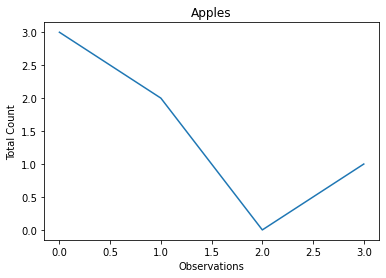

In [131]:
# sample graph over time
sample_data['apples'].plot(xlabel="Observations", ylabel="Total Count", title="Apples");

In [132]:
# We can also create a function to graph and handle labels for us

def plot(x, y, ax, title, x_label, y_label):
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.plot(x, y)

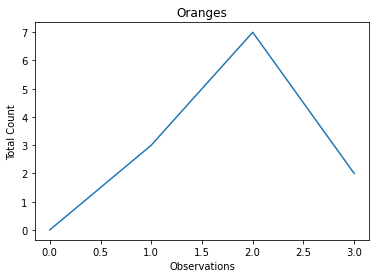

In [133]:
fig, ax = plt.subplots()
plot(sample_data.index, sample_data.oranges, ax, 'Oranges','Observations', 'Total Count')

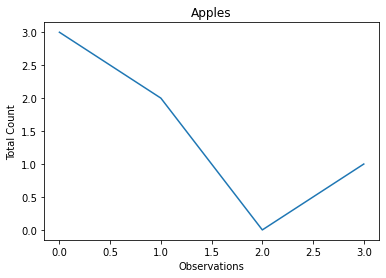

In [134]:
fig, ax = plt.subplots()
plot(sample_data.index, sample_data.apples, ax, 'Apples','Observations', 'Total Count')

---

## 🏙️ Pluto Data

The Primary Land Use Tax Lot Output (PLUTO) reports tax lot and building characteristics, and geographic/political/administrative districts at the tax lot level from data maintained by the Department of City Planning (DCP), Department of Finance (DOF), Department of Citywide Administrative Services (DCAS), and Landmarks Preservation Commission (LPC).

We will call the dataset via the [NYC Open Data Portal](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks/data) and download it into memory. 

This will take a moment, good time to refill your ☕ coffee.

[Pluto GitHub](https://github.com/NYCPlanning/db-pluto)

In [87]:
'''
Let's read in the Pluto dataset, which contains tax lot information in New York City. The head() function returns the first 5 rows of the dataset.
'''
# can either call the dataset from your local computer 
# pluto_data = pd.read_csv("../data/nyc_pluto_21v2_csv/pluto.csv")

# or through the NYC open data portal SODA API. This will take a moment - good time to refil your coffee.
pluto_data = pd.read_csv('https://data.cityofnewyork.us/resource/64uk-42ks.csv?$limit=900000')
print("There are {} rows in Pluto dataset".format(len(pluto_data)))
print()
pluto_data.head()

There are 859032 rows in Pluto dataset



,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,latitude,longitude,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,version,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate,geom,dcpedited,notes
0,MN,563,7502,102.0,61.0,2000.0,2.0,2.0,10003.0,L003,6.0,5700.0,1.0,3A,42 EAST 12 STREET,C6-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,R1,2.0,0.0,NaN,UNAVAILABLE OWNER,2643.0,10080.0,0.0,10080.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,7.0,6.0,6.0,26.50,103.00,0.00,0.0,NaN,0.0,False,5.0,5.0,292501.0,6494851.0,5800.0,1900.0,0.0,0.0,NaN,NaN,3.81,3.44,6.0,6.5,1,1.005638e+09,453.0,61.0,986475.0,206447.0,40.733326,-73.991972,12c,NaN,103 025,10207.0,NaN,1.005631e+09,1988-08-25T00:00:00.000,1,21v4,2.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BK,7133,65,315.0,392.0,1003.0,21.0,47.0,11223.0,E254,61.0,8610.0,3.0,5C,2105 OCEAN PARKWAY,R5,NaN,NaN,NaN,NaN,NaN,OP,NaN,NaN,NaN,False,A9,1.0,0.0,NaN,OCEAN PARKWAY BH 26 LLC,3445.0,5306.0,0.0,5306.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,1.0,26.50,130.00,17.00,97.0,N,1.0,False,5.0,2.0,18000.0,178800.0,0.0,2006.0,0.0,0.0,NaN,NaN,1.54,1.25,0.0,2.0,3,3.071330e+09,NaN,392.0,994016.0,157028.0,40.597676,-73.964833,28c,NaN,314 040,32106.0,NaN,NaN,NaN,1,21v4,15.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BK,7153,53,315.0,388.0,2002.0,21.0,47.0,11223.0,E254,61.0,8610.0,3.0,5C,2287 EAST 1 STREET,R4,NaN,NaN,NaN,NaN,NaN,OP,NaN,NaN,NaN,False,B3,1.0,0.0,NaN,2287E1 LLC,1500.0,1556.0,0.0,1556.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,25.00,60.00,20.67,38.0,N,2.0,False,5.0,1.0,6360.0,59580.0,0.0,1930.0,0.0,0.0,NaN,NaN,1.04,0.75,0.0,2.0,3,3.071530e+09,NaN,388.0,992704.0,155373.0,40.593135,-73.969560,28c,NaN,314 047,32107.0,NaN,NaN,NaN,1,21v4,15.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,QN,6865,402,408.0,450.0,1002.0,28.0,24.0,11432.0,E315,107.0,2810.0,4.0,2D,161-26 GRAND CENTRAL PKWY,R4B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,A5,1.0,0.0,NaN,CARLOS RODRIGUEZ,2925.0,1360.0,0.0,1360.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,20.08,145.67,20.00,34.0,G,3.0,False,5.0,2.0,15960.0,39060.0,1440.0,1935.0,0.0,0.0,NaN,NaN,0.46,0.90,0.0,2.0,4,4.068650e+09,NaN,450.0,1038622.0,200086.0,40.715699,-73.803864,14c,NaN,406 042,43103.0,NaN,NaN,NaN,1,21v4,8.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,QN,8658,14,413.0,1617.0,1013.0,26.0,23.0,11426.0,L162,105.0,2160.0,4.0,2C,244-14 91 AVENUE,R2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,A9,1.0,0.0,NaN,BASHIR IRFAN,6086.0,2256.0,0.0,2256.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,41.00,93.00,22.00,50.0,G,1.0,True,3.0,2.0,26280.0,44220.0,1440.0,1935.0,2008.0,0.0,NaN,NaN,0.37,0.50,0.0,1.0,4,4.086580e+09,NaN,1617.0,1060875.0,203891.0,40.725978,-73.723547,15c,NaN,422 037,43802.0,NaN,NaN,NaN,1,21v4,13.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Land Use Analysis

We are going to look at how land use is spatially distributed in Manhattan.

**Steps**

1. Get a list of Borough names
2. Get a list of unique landuse's
3. Filter to Manhattan and list all unique landuse's and the associated total counts

In [135]:
# New York Boroughs
'''
BX -> Bronx
MN -> Manhattan
BK -> Brooklyn
SI -> Staten Island
QN -> Queens
'''
list(pluto_data['borough'].unique())

['MN', 'BK', 'QN', 'BX', 'SI']

We can see `MN == 'Manhattan'`

In [136]:
'''
The function below filters to Manhattan, then grabs all the unique landuse values and counts them to give total counts by category of landuse
'''

# declare variable to filter dataset to just Manhattan
mn_lots = pluto_data[pluto_data['borough'] == 'MN']

# get total number of MN tax lots
total_mn_lots = len(mn_lots)
print(f'Total Manhattan tax lots:  {total_mn_lots}')

# get total number of all tax lots
total_lots = len(pluto_data)
print(f'Total tax lots:  {total_lots}')

print('Manhattan makes up {}% of all tax lots in the Pluto dataset'.format(round((total_mn_lots / total_lots * 100), 2)))

Total Manhattan tax lots:  42734
Total tax lots:  859032
Manhattan makes up 4.97% of all tax lots in the Pluto dataset


In [90]:
mn_lot_area = mn_lots['lotarea'].sum()
print(f'Manhattan lot area {mn_lot_area} sqft')

total_lot_area = pluto_data['lotarea'].sum()
print(f'total lot area {total_lot_area} sqft')

print(f'Manhattan makes up {round((mn_lot_area / total_lot_area * 100), 2)}% of all lot area in NYC')

Manhattan lot area 515302717.0 sqft
total lot area 6972782565.0 sqft
Manhattan makes up 7.39% of all lot area in NYC


In [91]:
mn_built_area = mn_lots['bldgarea'].sum()
print(f'Manhattan lot area {mn_lot_area} sqft')

total_built_area = pluto_data['bldgarea'].sum()
print(f'total lot area {total_lot_area} sqft')

print(f'Manhattan makes up {round((mn_built_area / total_built_area * 100), 2)}% of all buildng area in NYC')

Manhattan lot area 515302717.0 sqft
total lot area 6972782565.0 sqft
Manhattan makes up 32.47% of all buildng area in NYC


In [137]:
# Let's look at the landuse column, and see total counts of each category
mn_lots['landuse'].value_counts()

4.0     12077
2.0     11473
3.0      4933
5.0      4657
1.0      4115
8.0      2402
11.0     1032
9.0       594
10.0      575
7.0       525
6.0       208
Name: landuse, dtype: int64

We can see the landuses' are encoded by floats, we need to rename them by using the PDF found in the Pluto dataset.

[pluto-data-dictionary](../data/nyc_pluto_21v2_csv/PLUTODD21v2.pdf)

In [94]:
# renaming categories from Data Dictionary
land_use_dict = {
    1: "One & Two Family Buildings",
    2: "Multi-Family Walk-Up Buildings",
    3: "Multi-Family Elevator Buildings",
    4: "Mixed Residential & Commercial Buildings",
    5: "Commercial & Office Buildings",
    6: "Industrial & Manufacturing",
    7: "Transportation & Utility",
    8: "Public Facilities & Institutions",
    9: "Open Space & Outdoor Recreation",
    10: "Parking Facilities",
    11: "Vacant Land"
}

# apply rename
mn_lots['landuse_cat'] = mn_lots['landuse'].replace(land_use_dict)

In [95]:
'''
The function beloew gets the total counts of each land use category and sorts alphabetically
'''
mn_lots_landuse_counts = mn_lots['landuse_cat'].value_counts(ascending=False).to_frame().reset_index()
mn_lots_landuse_counts.columns = ['landuse_cat', 'count']
mn_lots_landuse_counts

,landuse_cat,count
0,Mixed Residential & Commercial Buildings,12077
1,Multi-Family Walk-Up Buildings,11473
2,Multi-Family Elevator Buildings,4933
3,Commercial & Office Buildings,4657
4,One & Two Family Buildings,4115
5,Public Facilities & Institutions,2402
6,Vacant Land,1032
7,Open Space & Outdoor Recreation,594
8,Parking Facilities,575
9,Transportation & Utility,525


We can see that the highest land use in Manhattan is Mixed Residential & Commerical Buildings with **12,077** total tax lots.

### Treemap

squarify is an algorithm for treemaps. Treemaps display hierarchical (tree-structured) data as a set of nested rectangles visualizing proportions in the given categorical data.

[squarify GitHub](https://github.com/laserson/squarify)

`pip install squarify`

In [96]:
import squarify

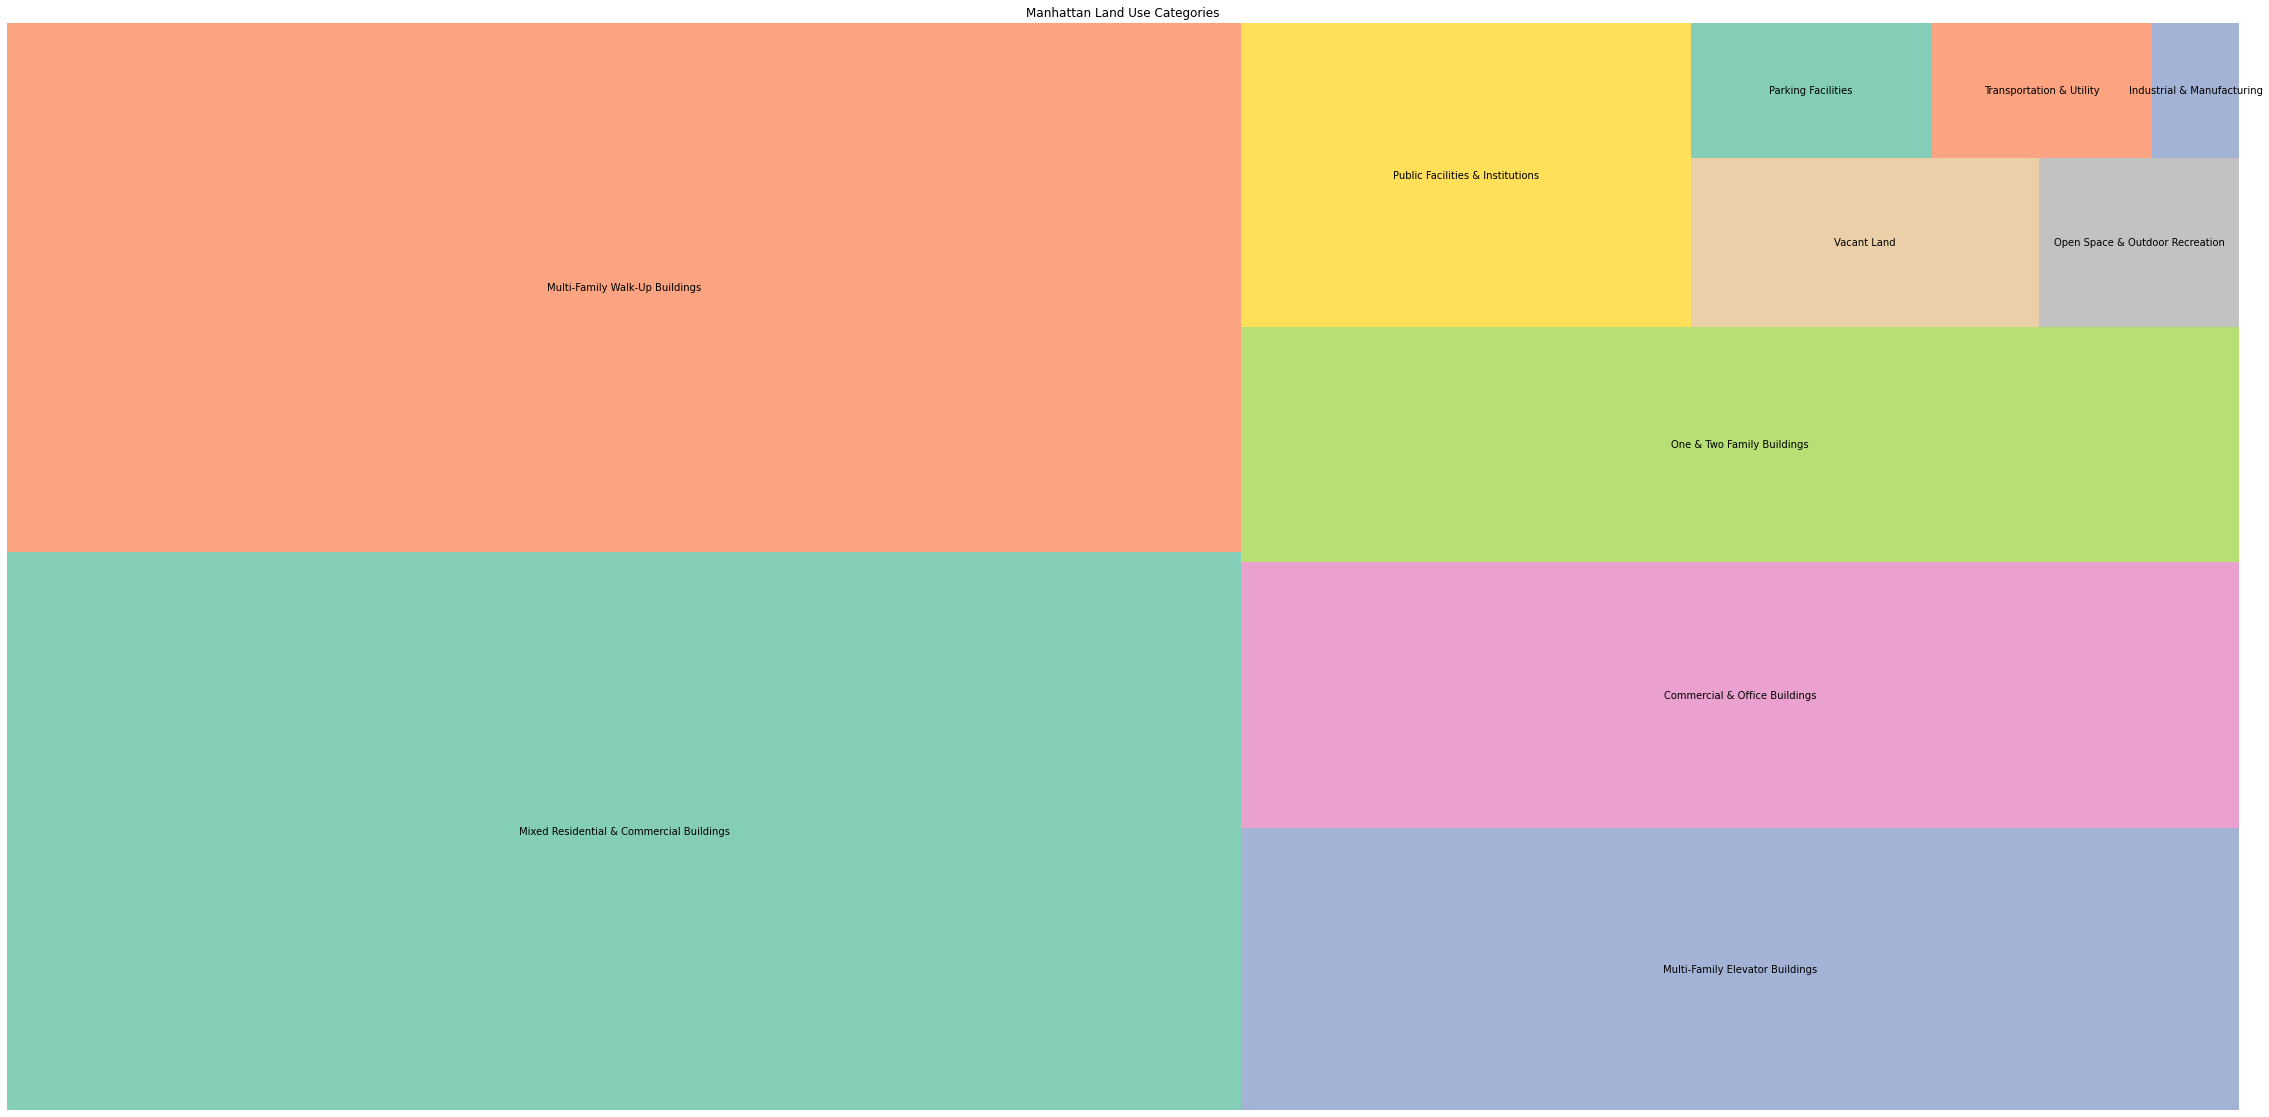

In [97]:
# plot it
plt.rcParams["figure.figsize"] = (40,20)
squarify.plot(sizes=mn_lots_landuse_counts['count'], label=mn_lots_landuse_counts['landuse_cat'], alpha=.8, color=plt.cm.Set2.colors)
plt.axis('off')
plt.title("Manhattan Land Use Categories")
plt.show()

## Spatial Anaytics with K-Means Clustering

### Geopandas

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and matplotlib for plotting.

[Installation link](https://geopandas.org/getting_started.html)

In [98]:
import geopandas as gpd

### SkLearn

`Scikit-learn` is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities. We will be using [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering to cluster simliar tax lots together and color them.

[Installation link](https://scikit-learn.org/stable/getting_started.html)

### K-means clustering

https://scikit-learn.org/stable/modules/clustering.html#k-means

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

In [99]:
# Use k-means package from sklearn
from sklearn.cluster import KMeans
from sklearn import preprocessing

![k-means](../imgs/kmeans_example.png)

In [100]:
# load in our shapefile data set from the data folder

mn_geo_lots = gpd.read_file('../data/manhattan_pluto_tax_lots.geojson')
mn_geo_lots = mn_geo_lots.fillna(0)
mn_geo_lots.head()

,Borough,Block,Lot,CD,LandUse,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,AreaSource,NumBldgs,NumFloors,LotFront,LotDepth,BldgFront,BldgDepth,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BBL,geometry
0,MN,1,101,101.0,08,541886.0,541886.0,541886.0,0.0,0.0,0.0,0.0,0.0,0.0,2,10.0,0.0,500.00,1046.00,0.0,0.0,0,INDIVIDUAL LANDMARK,1.00,0.5,0.0,1.0,1.000010e+09,"MULTIPOLYGON (((-74.04270 40.69006, -74.04256 ..."
1,MN,2,1,101.0,07,209215.0,280000.0,280000.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,5.0,314.28,564.84,268.0,210.0,0,0,1.34,0.0,2.0,6.5,1.000020e+09,"MULTIPOLYGON (((-74.01191 40.69972, -74.01218 ..."
2,MN,2,3,0.0,07,38800.0,7500.0,7500.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,1.0,91.90,564.56,50.0,75.0,0,0,0.19,10.0,3.4,10.0,1.000020e+09,"MULTIPOLYGON (((-74.01068 40.69996, -74.01113 ..."
3,MN,3,1,101.0,09,945425.0,945425.0,945425.0,0.0,0.0,0.0,0.0,0.0,0.0,2,7.0,1.0,323.00,1260.00,89.0,57.0,0,INDIVIDUAL LANDMARK,1.00,0.0,0.0,0.0,1.000030e+09,"MULTIPOLYGON (((-74.01478 40.70126, -74.01511 ..."
4,MN,3,3,101.0,09,33600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2.0,1.0,180.00,370.00,16.0,19.0,0,0,0.00,0.0,0.0,0.0,1.000030e+09,"MULTIPOLYGON (((-74.01276 40.70181, -74.01271 ..."


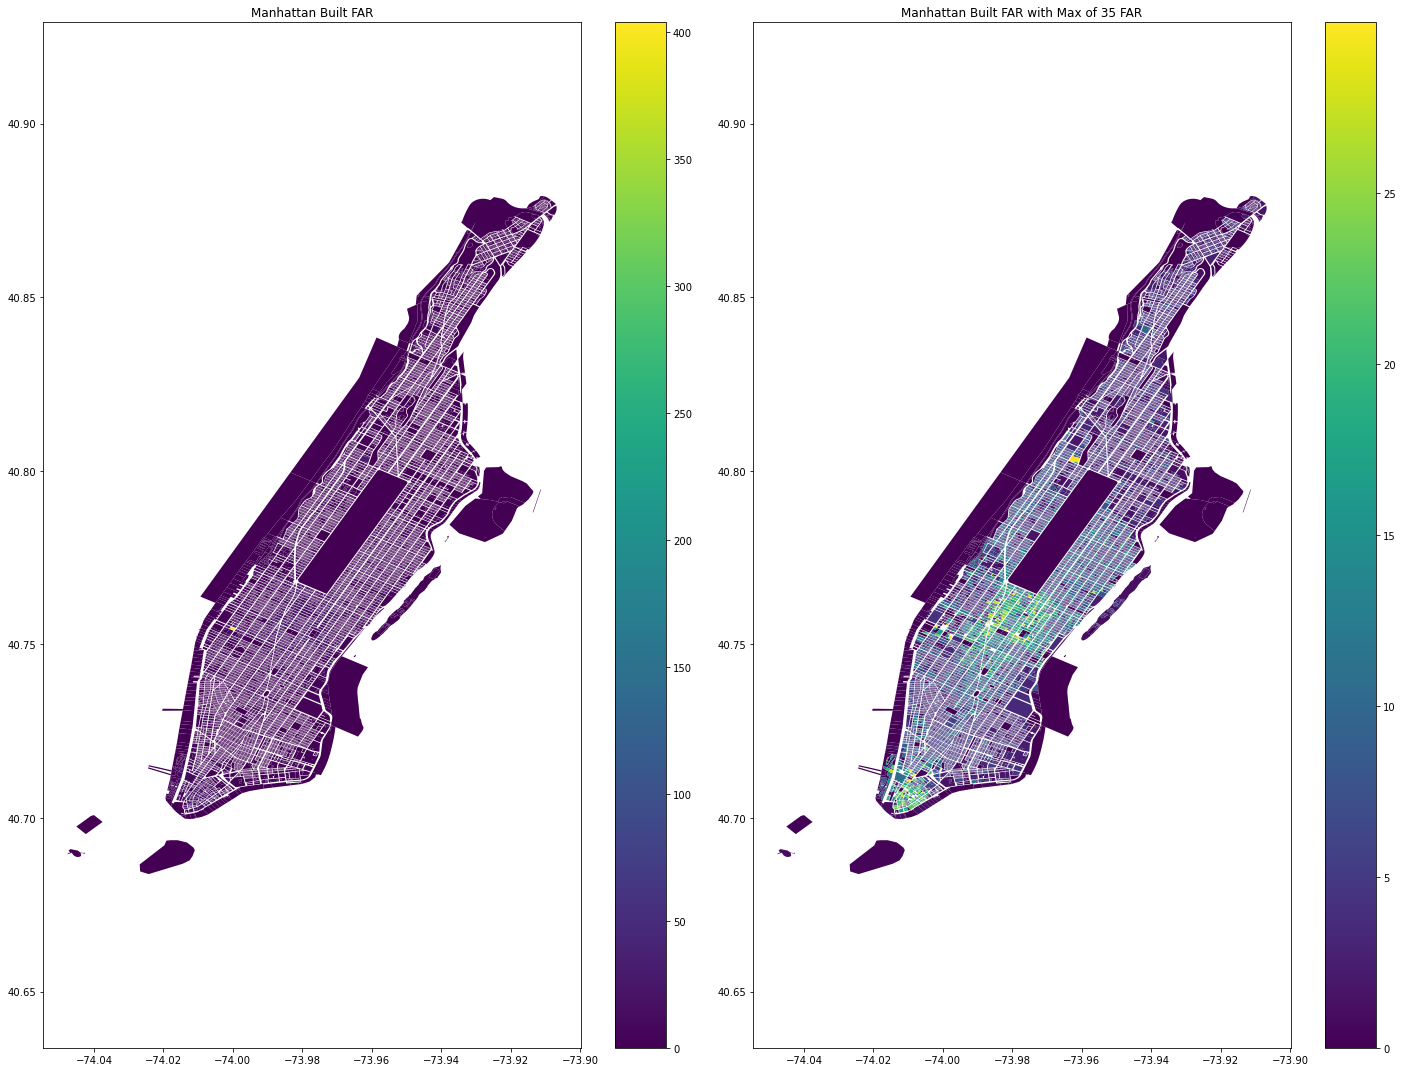

In [102]:
# let's create some maps

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(20,15))

mn_geo_lots.plot(column='BuiltFAR', legend=True, ax=ax1)
ax1.set_title('Manhattan Built FAR')
ax1.set_aspect('equal', adjustable='datalim')

max_far = 30
mn_geo_lots[mn_geo_lots['BuiltFAR'] <= max_far].plot(column='BuiltFAR', legend=True, ax=ax2);
ax2.set_title('Manhattan Built FAR with Max of 35 FAR')
ax2.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.show()

### ZoLa New York City's Zoning & Land Use Map

[ZOLA Tax Lot](https://zola.planning.nyc.gov/l/lot/1/1865/1?aerial-year=aerials-2016&layer-groups=%5B%22building-footprints%22%2C%22commercial-overlays%22%2C%22street-centerlines%22%2C%22subway%22%2C%22tax-lots%22%2C%22zoning-districts%22%5D&print=false&search=false&selectedFirm=%5B%22A%22%2C%22Shaded%20X%22%2C%22V%22%5D&selectedOverlays=%5B%22C1-1%22%2C%22C1-2%22%2C%22C1-3%22%2C%22C1-4%22%2C%22C1-5%22%2C%22C2-1%22%2C%22C2-2%22%2C%22C2-3%22%2C%22C2-4%22%2C%22C2-5%22%5D&selectedPfirm=%5B%22A%22%2C%22Shaded%20X%22%2C%22V%22%5D&selectedZoning=%5B%22BP%22%2C%22C1%22%2C%22C2%22%2C%22C3%22%2C%22C4%22%2C%22C5%22%2C%22C6%22%2C%22C7%22%2C%22C8%22%2C%22M1%22%2C%22M2%22%2C%22M3%22%2C%22PA%22%2C%22R1%22%2C%22R10%22%2C%22R2%22%2C%22R3%22%2C%22R4%22%2C%22R5%22%2C%22R6%22%2C%22R7%22%2C%22R8%22%2C%22R9%22%5D&shouldRefresh=false#15.56/40.803494/-73.958072)

![ZOLA-img](../imgs/zola_screenshot.png)

### Cathedral of Cathedral of St John the Divine

[wiki](https://en.wikipedia.org/wiki/Cathedral_of_St._John_the_Divine)

![Cathedral](../imgs/cathedral.png)

In [103]:
# uncomment different cluster_data arrays to analyze tax lots and see which ones are simliar to one another based on tax lot characterstics using k-means clustering
# cluster_data = mn_geo_lots[['LandUse', 'LotArea', 'BuiltFAR','NumBldgs']]
cluster_data = mn_geo_lots[['LandUse', 'ResidFAR', 'CommFAR','FacilFAR', 'NumFloors']]
cluster_data.head()

,LandUse,ResidFAR,CommFAR,FacilFAR,NumFloors
0,08,0.5,0.0,1.0,0.0
1,07,0.0,2.0,6.5,5.0
2,07,10.0,3.4,10.0,1.0
3,09,0.0,0.0,0.0,1.0
4,09,0.0,0.0,0.0,1.0


### ➰ Looping through different clusters

K-means algorithm inputs the desired number of clusters, we typically decide the number of clusters based on what your call the *elbow* of the Mean-Squared-Errors (MSE) where the clusters are stable and the algorithm can correctly disgintugish between different clusters effectively.

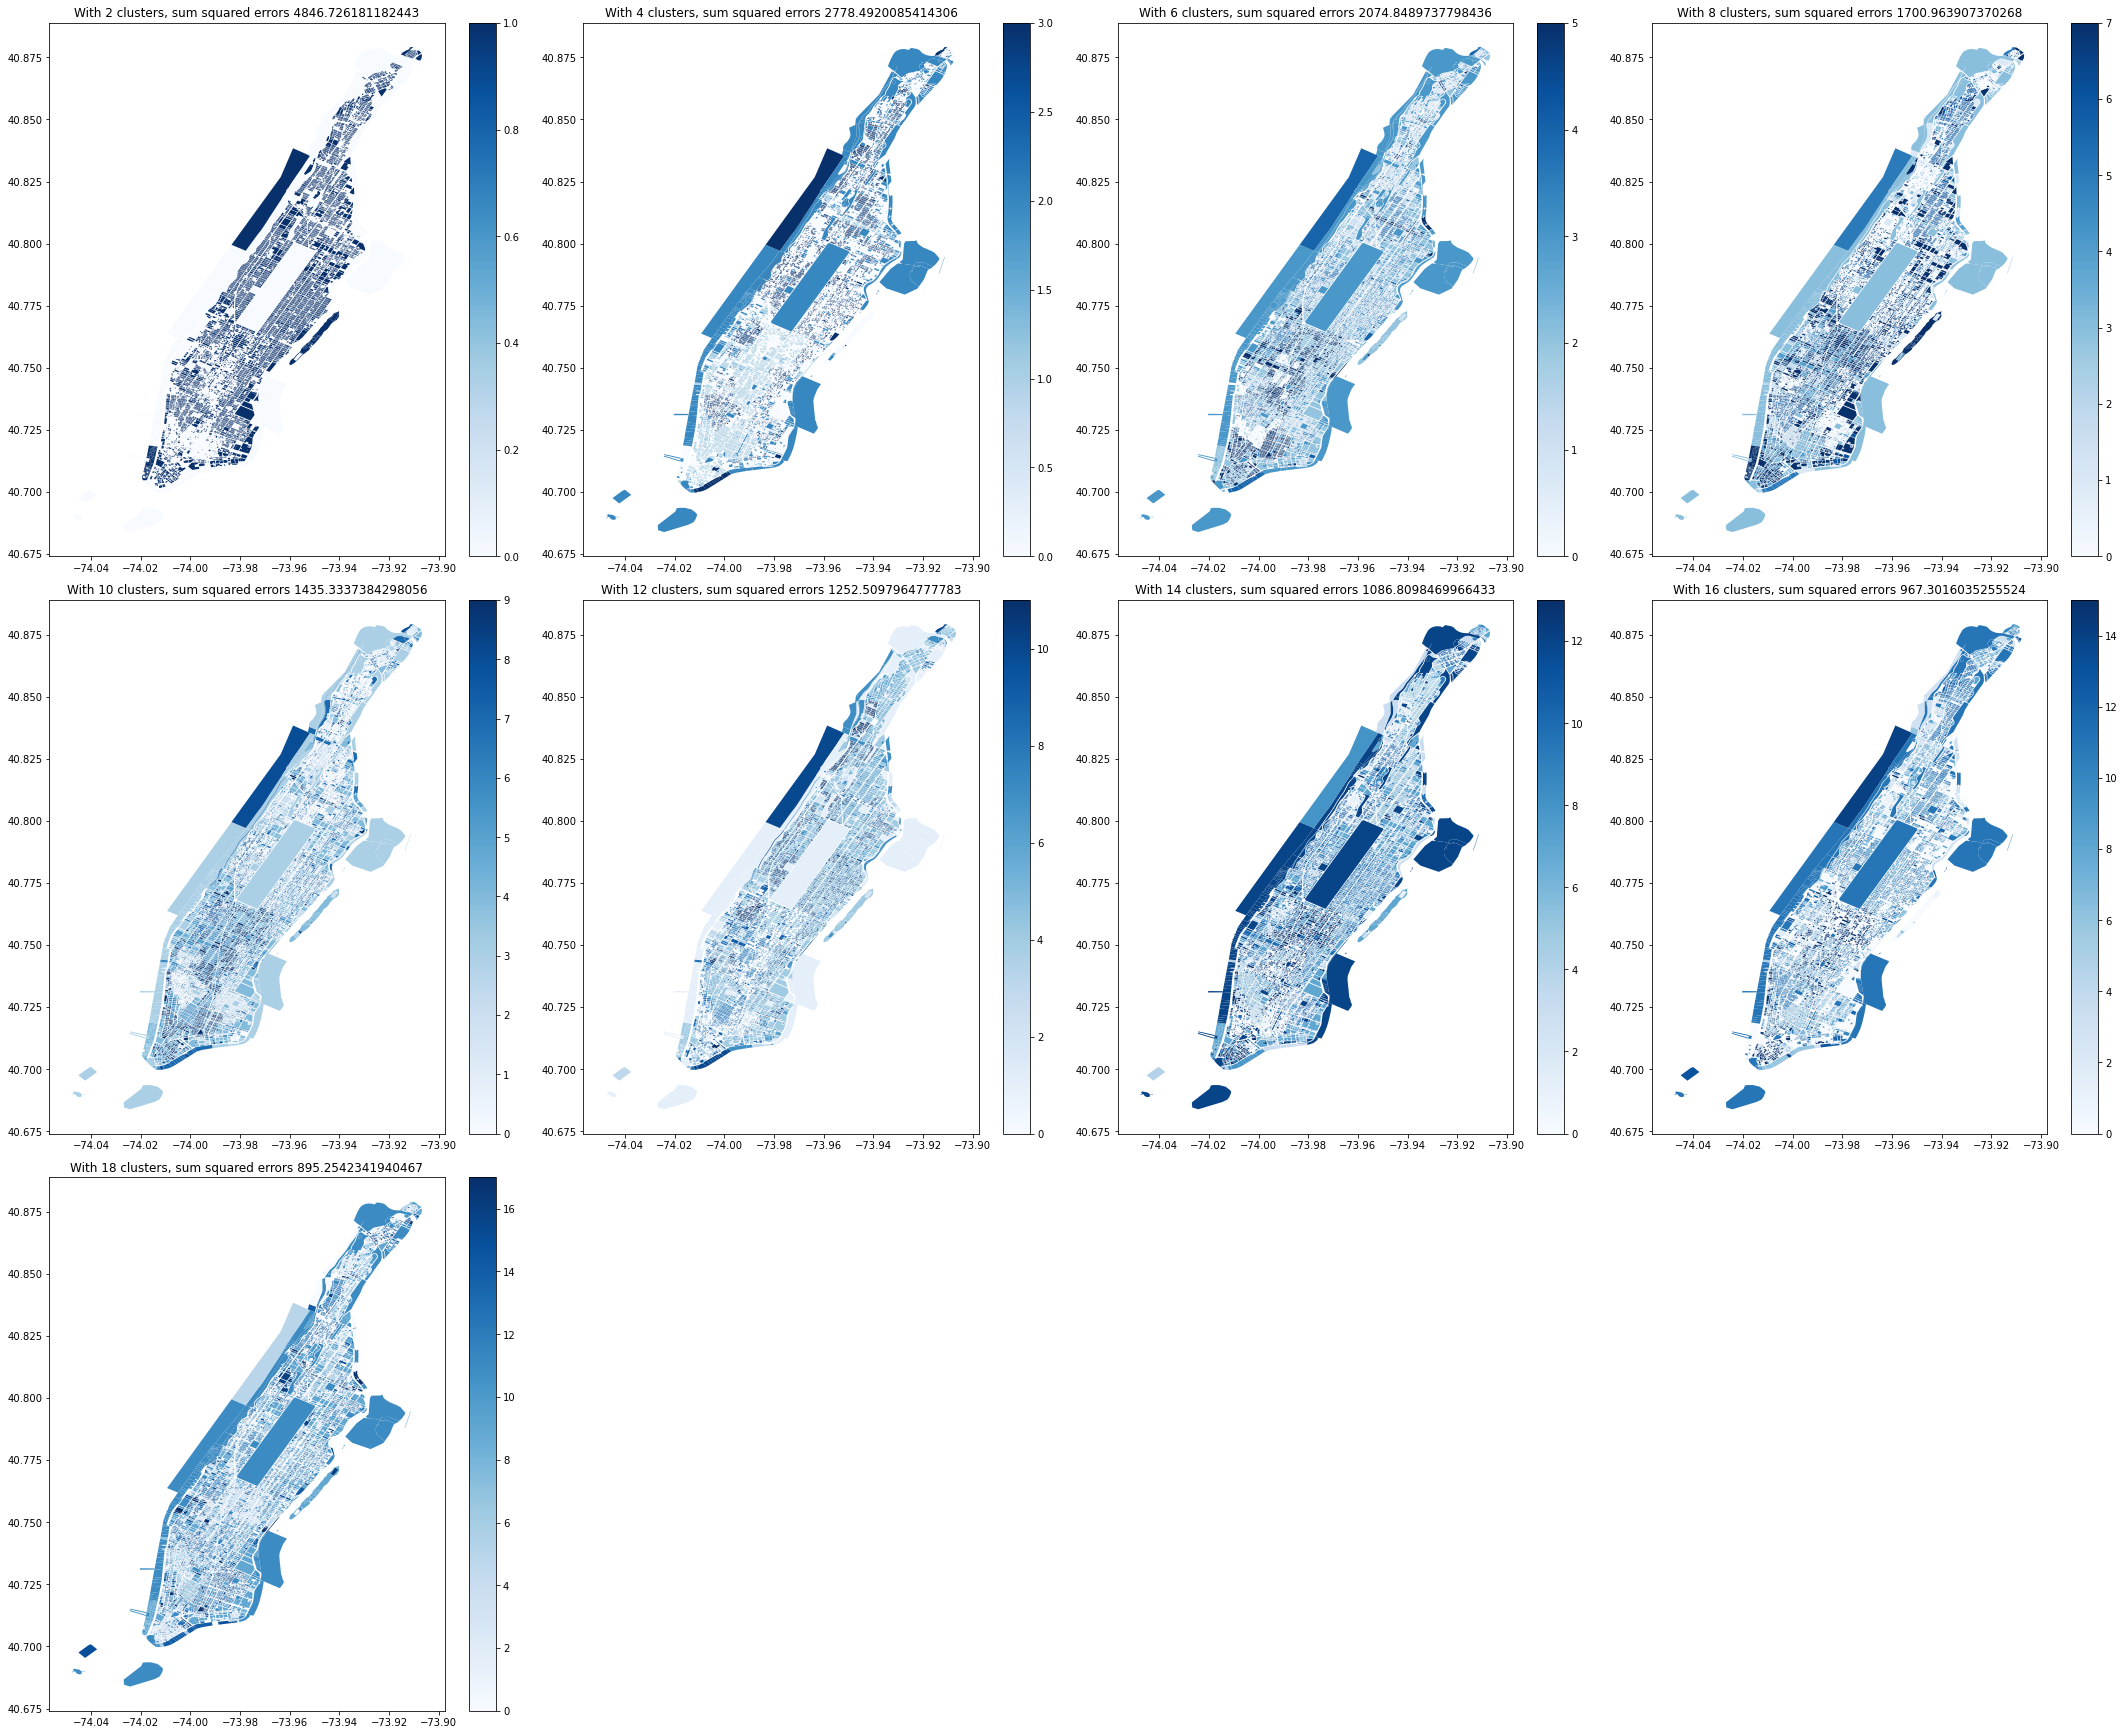

In [104]:
plt.figure(figsize=(30,40))

ind = 0

# create dict to store scores
clusters = {
    'clusters': [],
    'score':[]
}

# normalize the data before running the model
norm_cluster_data = preprocessing.normalize(cluster_data)

for i in np.arange(2,20, 2):

    ax = plt.subplot(5,4, ind+1)
    
    ind+=1

    # run kmeans model
    
    km = KMeans(random_state=234,n_clusters=i).fit(norm_cluster_data)
    res=km.predict(norm_cluster_data)
    
    mn_geo_lots['cluster_cat'] = res

    # create title with number of clusters and MSE ( mean squared error )
    title = f'With {i} clusters, sum squared errors {km.inertia_}'
    # plot the viz
    mn_geo_lots.plot(column='cluster_cat', legend=True, figsize=(20,20), ax=ax, cmap='Blues')
    # set title
    ax.set_title(title)
    # aspect ratio
    ax.set_aspect('equal', adjustable='datalim')

    clusters['clusters'].append(i)
    clusters['score'].append(km.inertia_)

plt.tight_layout()
plt.show()

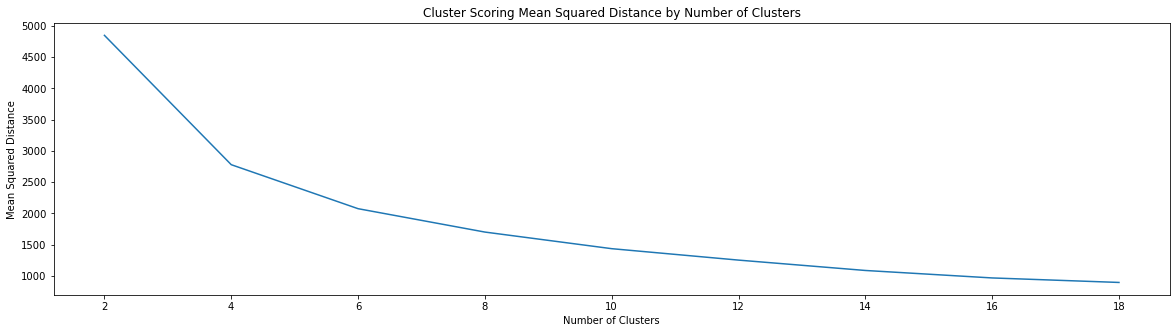

In [105]:
cluster_scores = pd.DataFrame.from_dict(clusters, orient='index').transpose()
fig, ax = plt.subplots(figsize=(20,5))
plot(cluster_scores.clusters, cluster_scores.score, ax, 'Cluster Scoring Mean Squared Distance by Number of Clusters','Number of Clusters', 'Mean Squared Distance')

Mean squared distance of each cluster shows how *tight* each cluster is, meaning the smaller the *Mean Squared Distance* the easier it is for the k-means algorithm to distingush one cluster from another. We use the *elbow* method to see where the graph has an inflection point where what we gain in intelligence is minimal or the elbow like an arm!

We can see the *elbow* at *10* or maybe *12* clusters creates distinct enough variation in the dataset.

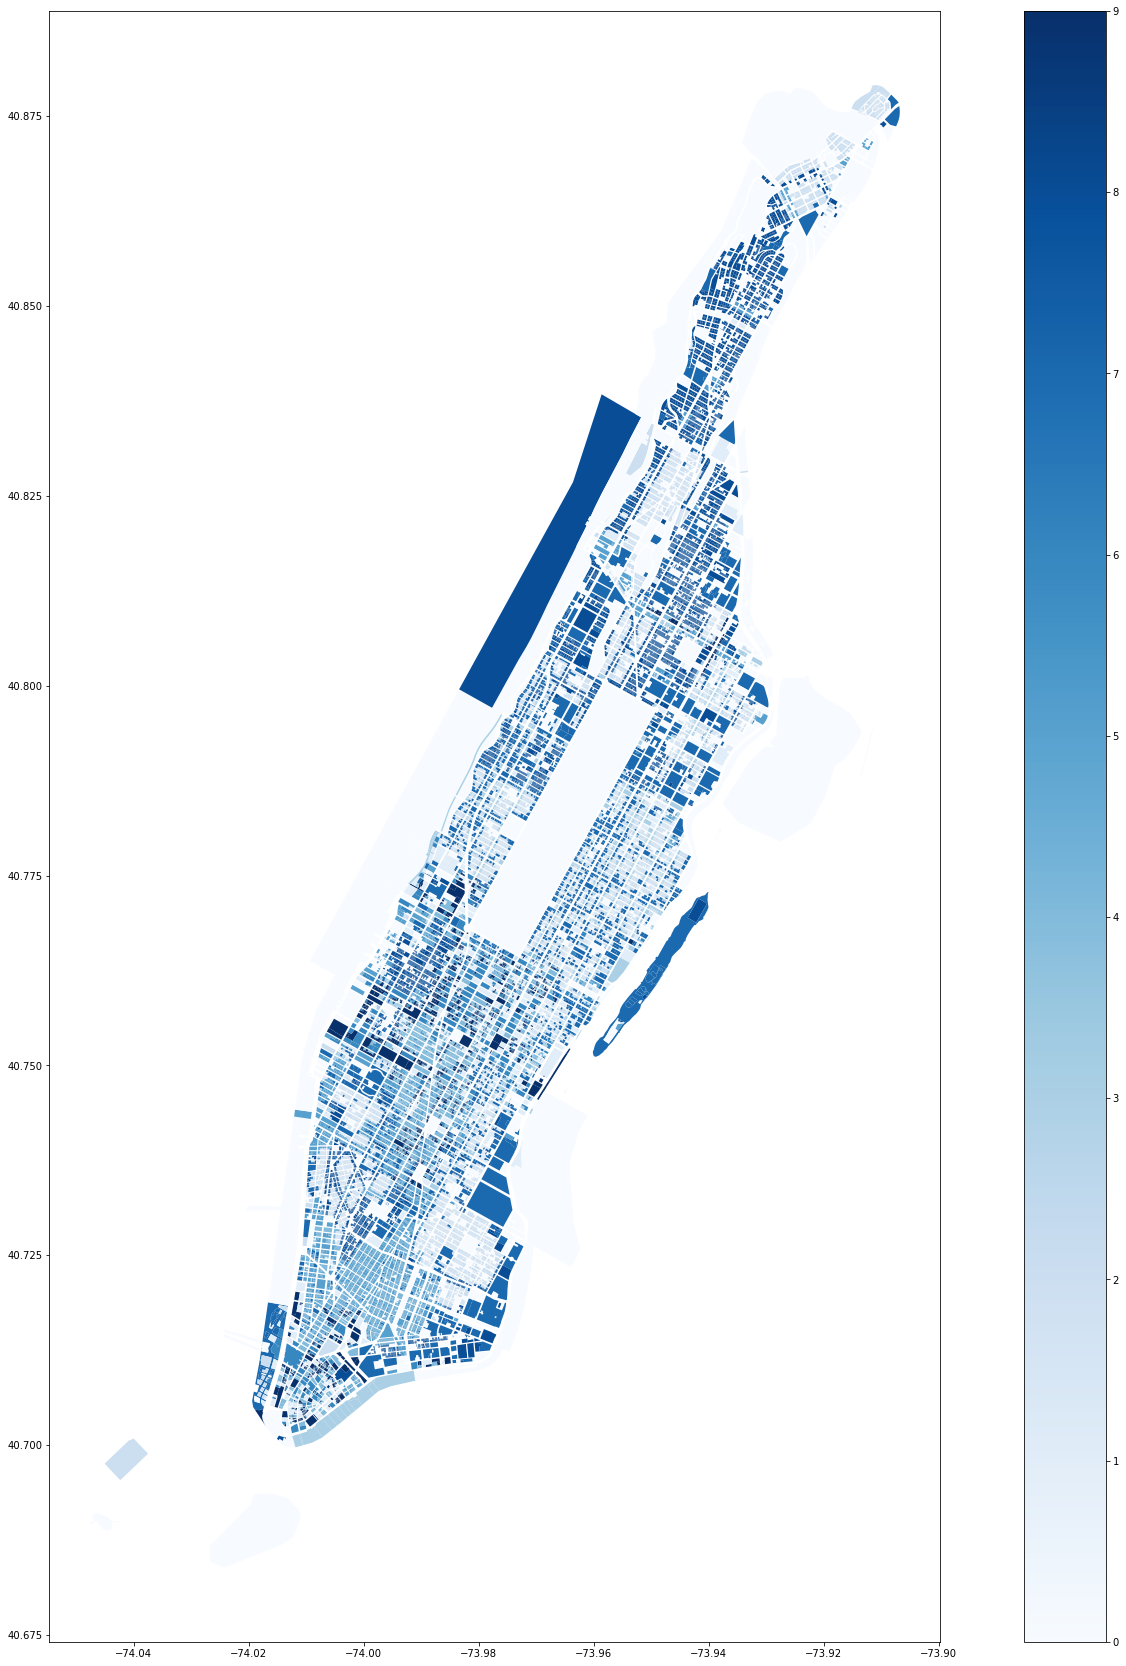

In [106]:
optimal_number_clusters = 10

km = KMeans(random_state=234,n_clusters=optimal_number_clusters).fit(cluster_data)
res=km.predict(cluster_data)
mn_geo_lots['cluster_cat'] = res
mn_geo_lots.plot(column='cluster_cat', legend=True, cmap='Blues', figsize=(30,30));

## Save data to Rhino 3dm

### Rhino 3dm

[Rhino3dm](https://pypi.org/project/rhino3dm/) is a set of libraries based on the OpenNURBS geometry library with a "RhinoCommon" style. This provides the ability to access and manipulate geometry through .NET, Python or JavaScript applications independent of Rhino.

[Rhino3dm Link](https://github.com/mcneel/rhino3dm)

`pip install rhino3dm`

[Rhino Compute Link](https://pypi.org/project/compute-rhino3d/)

`pip install compute-rhino3d`

In [107]:
# rhino 3dm import
# from rhino3dm import *
import rhino3dm as rhino3dm
import compute_rhino3d.Util

#### Geopandas to Rhino 3dm

Let's convert the Geopandas Dataframe back into Rhino Geometry using the [Rhino3dm](https://pypi.org/project/rhino3dm/) library.

In [108]:
# init file object constructor
_file = rhino3dm.File3dm()

# loop through GeoDataFrame
for index, row in mn_geo_lots.iterrows():

    # init constructors to build polygons with data
    _points = rhino3dm.Point3dList()
    att = rhino3dm.ObjectAttributes()

    # loop through the geometry data
    for pt in list(row['geometry'][0].exterior.coords):
        _points.Add(pt[0],pt[1], 0)

    # create curve
    curve = rhino3dm.NurbsCurve.Create(False, 1, _points)
    # scale curve to meters
    curve.Scale(100000)
    # add data to UserString
    att.SetUserString('cluster', str(row['cluster_cat']))

    # add to file object
    _file.Objects.AddCurve(curve, att)

# set units to Meters
_file.Settings.ModelUnitSystem = rhino3dm.UnitSystem(4)

# save to disk
_file.Write('../Rhino/manhattan_cluster_tax_lots.3dm')

print('Finished writing to disk')

Finished writing to disk


## Grasshopper + HOPS

1. Open Rhino 7
2. type `PackageManger` in the Rhino command line.
3. search for *Hops*
4. Select *Hops* and install
5. Restart Rhino

[Hops Website Link](https://developer.rhino3d.com/guides/grasshopper/hops-component/)

In [139]:
# Rhino compute by default launches on port 6500
compute_url = "http://localhost:6001/"

# set the URL
compute_rhino3d.Util.url = compute_url
# no auth token required
compute_rhino3d.Util.authToken = ""

# test, should return version object
version_test = requests.get(compute_url + '/version')
json.loads(version_test.content)

{'rhino': '7.16.22067.13001', 'compute': '1.0.0.0', 'git_sha': None}

In [111]:
'''
Rhino 3dm Encoder
'''

class __Rhino3dmEncoder(json.JSONEncoder):
    def default(self, o):
        if hasattr(o, "Encode"):
            return o.Encode()
        return json.JSONEncoder.default(self, o)

def getCurves(objs):
    curves = [item.Geometry for item in objs if item.Geometry.ObjectType == rhino3dm.ObjectType.Curve]
    return json.dumps(curves, cls=__Rhino3dmEncoder)

def getBreps(objs):
    breps = [item.Geometry for item in objs if item.Geometry.ObjectType == rhino3dm.ObjectType.Brep]
    return list(map(lambda x: {"type":"Rhino.Geometry.Brep","data":json.dumps(x, cls=__Rhino3dmEncoder)}, breps))

In [142]:
'''
Load Rhino 3dm model via File3dm.Read
'''

rhino_dir = "../Rhino/bryant_park/"
model_path = "bryant_park.3dm"
gh_path = "geometry"
file_path = rhino_dir + model_path
print(file_path)
# read the 3dm file
rhFile = rhino3dm.File3dm.Read(file_path)

# get site curve
curves = getCurves(rhFile.Objects)

# encode the geometry for transit
site_curve = json.loads(curves)[0]
site_curve = json.dumps(site_curve)

context_breps = getBreps(rhFile.Objects);

print('Geometry encoded ready to go!')

../Rhino/bryant_park/bryant_park.3dm
Geometry encoded ready to go!


## Load Grasshopper Geometry Generation File

**Inputs**

- site ( curve )
- open_space_ratio ( float )
- floor_height ( num )

**Outputs**

- open_space_area ( num )
- geometry (geometry | Breps)
- boundary (geometry | Polyline Curve )
- max_open ( Num | float )
- max_area ( Num | float )

![geometry.gh](../imgs/analysis_flow-01.png)

#### Load Grasshopper files

In [113]:
gh_geo = open(r"../Rhino/geometry.ghx", mode="r", encoding="utf-8-sig").read()
gh_geo_bytes = gh_geo.encode("utf-8")
gh_geo_encoded = base64.b64encode(gh_geo_bytes)
gh_geo_decoded = gh_geo_encoded.decode("utf-8")

gh_daylight = open(r"../Rhino/daylight.ghx", mode="r", encoding="utf-8-sig").read()
gh_daylight_bytes = gh_daylight.encode('utf-8')
gh_daylight_encoded = base64.b64encode(gh_daylight_bytes)
gh_daylight_decoded = gh_daylight_encoded.decode("utf-8")

## Prepare Request Payload

In [114]:
# Inputs

# adjust between 0 and 0.9
open_space_ratio = 0.6

# adjust between 1 and 50
floor_height = 20

# ---------------------

# payload
geo_payload = {
    "algo": gh_geo_decoded,
    "pointer": None,
    "values": [
        {
            "ParamName": "open_space_ratio",
            "InnerTree": {
                "{ 0; }": [
                    {
                        "type": "System.Double",
                        "data": open_space_ratio
                    }
                ]
            }
        },
        {
            "ParamName": "floor_height",
            "InnerTree":{
                "{ 0; }": [
                    {
                        "type": "System.Double",
                        "data": floor_height
                    }
                ]
            }
        },
        {
            "ParamName": "site",
            "InnerTree":{
                "{ 0; }": [
                    {
                        "type": "Rhino.Geometry.Curve",
                        "data": site_curve
                    }
                ]
            }
        }
    ]
}

# send HTTP request to Rhino Compute Server
res = requests.post(compute_url + "grasshopper", json=geo_payload)

# print("status code: {}".format(res.status_code))

# deserialize response object
response_object = json.loads(res.content)['values']

geometry_output = [result for result in response_object if result['ParamName'] == 'RH_OUT:geometry'][0]['InnerTree']['{0;0;0;0;0}']
print("number of buildings generated: {}".format(len(geometry_output)))

floor_area = [result for result in response_object if result['ParamName'] == 'RH_OUT:max_area'][0]['InnerTree']['{0}'][0]['data']
print('max floor area: {}'.format(floor_area))

floor_area = [result for result in response_object if result['ParamName'] == 'RH_OUT:max_open'][0]['InnerTree']['{0}'][0]['data']
print('max open area: {}'.format(floor_area))

number of buildings generated: 51
max floor area: 135140.20599860823
max open area: 10368.8544921875


In [115]:
daylight_payload = {
    "algo": gh_daylight_decoded,
    "pointer": None,
    "values": [
        {
            "ParamName": "weather_file",
            "InnerTree": {
                "{ 0; }": [
                    {
                        "type": "System.String",
                        "data": "F://KPF//Projects//Weather_Analysis//epws//USA_NY_New.York-Central.Park.725033_TMY3.epw"
                    }
                ]
            }
        },
        {
          "ParamName": "building",
          "InnerTree": {
            "{ 0; }": geometry_output
          }
        },
        {
            "ParamName": "site_curve",
            "InnerTree":{
                "{ 0; }": [
                    {
                        "type": "Rhino.Geometry.Curve",
                        "data": site_curve
                    }
                ]
            }
        }
    ]
}

# send HTTP Request
res = requests.post(compute_url + "grasshopper", json=daylight_payload)

# print("status code: {}".format(res.status_code))

# deserialize the response object
daylight_response_object = json.loads(res.content)['values']

# daylight_response_object
daylight_hours = [result for result in daylight_response_object if result['ParamName'] == 'RH_OUT:daylight_result'][0]['InnerTree']['{0;0}'][0]['data']
print('Total Daylight hours for March to December: {}'.format(daylight_hours))

Total Daylight hours for March to December: 18443.0


---

## Optional Advanced Workflow

The workflow queries the Pluto REST API for a shapefile by address. By using the [HERE API](https://developer.here.com/sign-up?create=Freemium-Basic&keepState=true&step=account) using the [Routing API](https://developer.here.com/products/routing) we can create [isochrones](https://en.wikipedia.org/wiki/Isochrone_map) based on walking distance from the given address.

### Pluto and HERE API

We can do spatial analytics by using a specifc address. Looking at data from the NYC Pluto dataset and pedestiran walking distance.

In [116]:
from shapely.geometry import Polygon

# folium import
import folium
import flexpolyline as fp
import json

### Query for Isoline

An Isoline polygon shows how far someone can travel given a set mode and unit of transportation. In the example below, we query how far a pedestrian can walk from the given address in 15 minutes and visualize the results spatially

In [117]:
from funcs import getKey

# kpf New York office address
kpf_office = "11 W 42nd St, New York, NY 10036"

# geocodes the address
url = 'https://nominatim.openstreetmap.org/search/' + requests.utils.requote_uri(kpf_office) +'?format=json'
response = requests.get(url).json()[0]

# query lon/lat
_lon = response['lon']
_lat = response['lat']

# mode of transportation, car, pedestrian
mode = 'pedestrian'
# starting point, using the above address lon/lat
origin = [_lat, _lon]
# distance in minutes, converetd to seconds in API call
distance = 15
# should we take the fastest route?
routingMode = 'fast'
# type of travel calculation, time, distance
rangeType = 'time'
# api key - create your own here for free
apikey = getKey()

# API string
API = "https://isoline.router.hereapi.com/v8/isolines?\
transportMode={}&origin={},{}\
&range[type]={}&range[values]={}\
&routingMode={}\
&apikey={}".format(mode, origin[0], origin[1], rangeType, distance*60, routingMode,apikey)

print('Quereid pedestrian walking distance from {} in {} minutes'.format(kpf_office, (distance)))

res = requests.get(API)

if(res.status_code == 200):
    res = json.loads(res.text)
    print('call successful and converted to json')

# decode HERE API response and reverse lat/lng order for geopandas
isoline_points = fp.decode(res['isolines'][0]['polygons'][0]['outer'])

isoline_pts = []
for p in isoline_points:
    isoline_pts.append(p[::-1])

isoline_polygon = Polygon(isoline_pts)
isoline_polygon = gpd.GeoSeries(isoline_polygon).to_json();

Quereid pedestrian walking distance from 11 W 42nd St, New York, NY 10036 in 15 minutes
call successful and converted to json


### Pluto Tax Lot

We can query a Pluto Tax lot through the [NYC DCP open API](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks) by address. Given an address we can get all the Pluto tax lot data, and visualize the given tax lot.

In [118]:
# Inputs
# how far in meters should we query
search_distance = 5

# https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/64uk-42ks
pluto_URL = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query?where=1%3D1&outFields=*&geometry={}%2C{} \
&geometryType=esriGeometryPoint&inSR=4326&spatialRel=esriSpatialRelIntersects&distance={}&units=esriSRUnit_Meter&outSR=4326&f=json".format(_lon, _lat, search_distance)

# get pluto lots
pluto_lots = requests.get(pluto_URL).json()

# gdf = gpd.GeoDataFrame()

# loop through lot features
for lot in pluto_lots['features']:

    # base dict
    prop = lot['attributes']

    # Pluto properties
    add = prop['Address']
    far = prop['BuiltFAR']
    num_floors = prop['NumFloors']
    lot_front = prop['LotFront']
    lot_depth = prop['LotDepth']
    
    print('FAR: {}'.format(far))
    print('Lot Front: {}'.format(lot_front))
    print('Lot Depth: {}'.format(lot_depth))

    # geometry
    geo = lot['geometry']['rings']
    lon = [x[0] for x in geo[0]]
    lat = [x[1] for x in geo[0]]
    
    curve_cart = zip(lon, lat)

    # create polygon of tax lot
    polygon_geom = Polygon(zip(lon, lat))

# create interactive map at address coordinate
mapo = folium.Map([_lat, _lon], zoom_start=15, tiles='cartodbpositron')

# add isoline polygon to map
isoline_polygon = folium.GeoJson(data=isoline_polygon,style_function=lambda x: {'fillColor': 'steelblule', 'opacity': 0.4})
isoline_polygon.add_to(mapo)

# add tax lot to map
sim_geo = gpd.GeoSeries(polygon_geom).to_json()
geo_j = folium.GeoJson(data=sim_geo,style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(mapo)

# show map!
mapo

FAR: 27.7
Lot Front: 191.67
Lot Depth: 200.83
